In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math

In [2]:
sequence_length = 30
window_size = 10
epochs = 100
batch_size = 64

print("Starting RUL Prediction Pipeline for FD001...")

Starting RUL Prediction Pipeline for FD001...


In [3]:
print("\nStep 1: Loading Data and Initial Preprocessing...")
col_names = ['unit', 'time', 'op_set1', 'op_set2', 'op_set3'] + \
            [f'sensor{i}' for i in range(1, 22)]

df = pd.read_csv('train_FD001.txt', sep=' ', header=None)
df.drop([26, 27], axis=1, inplace=True)
df.columns = col_names
print("Training data loaded successfully.")


Step 1: Loading Data and Initial Preprocessing...
Training data loaded successfully.


In [4]:
print("Step 2: Calculating RUL (No Clipping)...")
df['RUL'] = df.groupby('unit')['time'].transform('max') - df['time']
print("RUL calculated.")

Step 2: Calculating RUL (No Clipping)...
RUL calculated.


In [5]:
print("Step 3: Performing Feature Engineering (Rolling Statistics)...")
constant_sensors = ['sensor1', 'sensor5', 'sensor6', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
selected_sensor_cols = [col for col in [f'sensor{i}' for i in range(1, 22)] if col not in constant_sensors]
op_set_cols = ['op_set1', 'op_set2', 'op_set3']

rolling_features_base = op_set_cols + selected_sensor_cols

for col in rolling_features_base:
    df[f'{col}_rolling_mean_{window_size}'] = df.groupby('unit')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    df[f'{col}_rolling_std_{window_size}'] = df.groupby('unit')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())

df.fillna(0, inplace=True)

features_to_scale = rolling_features_base.copy()
for col in rolling_features_base:
    features_to_scale.append(f'{col}_rolling_mean_{window_size}')
    features_to_scale.append(f'{col}_rolling_std_{window_size}')

print(f"Total number of features after adding rolling statistics: {len(features_to_scale)}")
print("Feature engineering complete.")

Step 3: Performing Feature Engineering (Rolling Statistics)...
Total number of features after adding rolling statistics: 51
Feature engineering complete.


In [6]:
print("Step 4: Scaling Features...")
scaler = MinMaxScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
print("Features scaled.")

Step 4: Scaling Features...
Features scaled.


In [7]:
print("Step 5: Generating Sequences for LSTM and Splitting Data...")
X, y = [], []
units = df['unit'].unique()
np.random.shuffle(units)

train_units = units[:int(len(units) * 0.8)]
val_units = units[int(len(units) * 0.8):]

X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []

for unit_id in df['unit'].unique():
    unit_data = df[df['unit'] == unit_id]
    for i in range(len(unit_data) - sequence_length + 1):
        sequence = unit_data.iloc[i : i + sequence_length][features_to_scale].values
        target_rul = unit_data.iloc[i + sequence_length - 1]['RUL']

        if unit_id in train_units:
            X_train_list.append(sequence)
            y_train_list.append(target_rul)
        elif unit_id in val_units:
            X_val_list.append(sequence)
            y_val_list.append(target_rul)

X_train = np.array(X_train_list)
y_train = np.array(y_train_list)
X_val = np.array(X_val_list)
y_val = np.array(y_val_list)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print("Sequences generated and data split.")

Step 5: Generating Sequences for LSTM and Splitting Data...
Shape of X_train: (14033, 30, 51)
Shape of y_train: (14033,)
Shape of X_val: (3698, 30, 51)
Shape of y_val: (3698,)
Sequences generated and data split.


In [8]:
print("\nStep 6: Building and Compiling LSTM Model...")
model = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=64, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()
print("Model built and compiled.")


Step 6: Building and Compiling LSTM Model...


C:\Users\DELL\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 128)             │          92,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,633 (553.25 KB)

 Trainable params: 141,633 (553.25 KB)

 Non-trainable params: 0 (0.00 B)

Model built and compiled.


In [9]:
print("\nStep 7: Training the LSTM Model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)
print("Model training complete.")


Step 7: Training the LSTM Model...
Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 10453.1992 - val_loss: 9574.3027
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 7978.6636 - val_loss: 7851.3350
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 6695.3677 - val_loss: 6612.7134
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 5466.3926 - val_loss: 5728.6172
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 4835.8540 - val_loss: 5124.1753
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 4446.1924 - val_loss: 4732.2529
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 4113.6699 - val_loss: 4486.1401
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 4082.5457 - val_loss: 4339.2583
Epoch 9/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 3983.7717 - val_loss: 4253.8330
Epoch 10/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 3852.7964 - val_loss: 4208.5889
Epoch 11/100
220/220


Step 8: Re-evaluating Model Performance on Validation Data...
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Validation MSE: 882.7369
Validation RMSE: 29.7109
Validation MAE: 19.8962


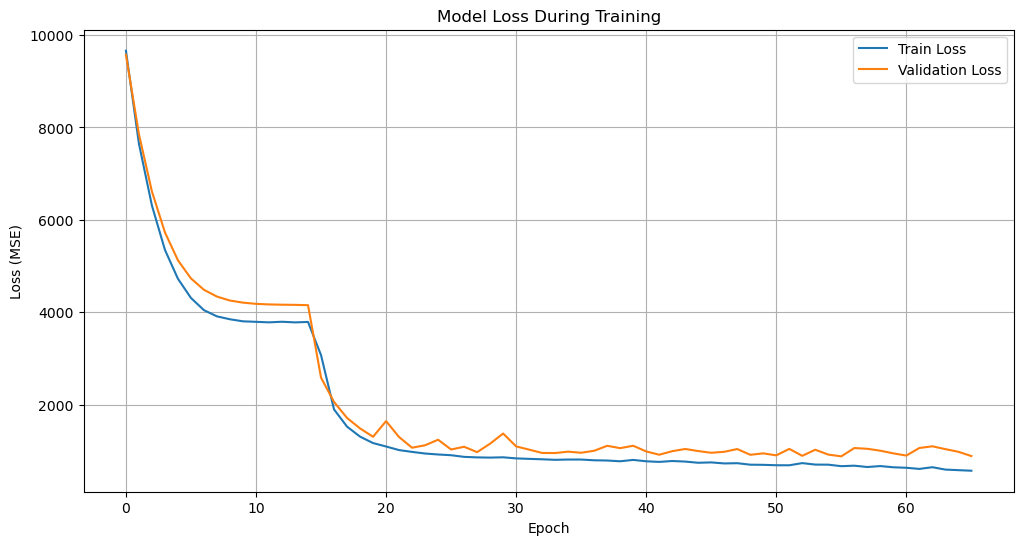

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


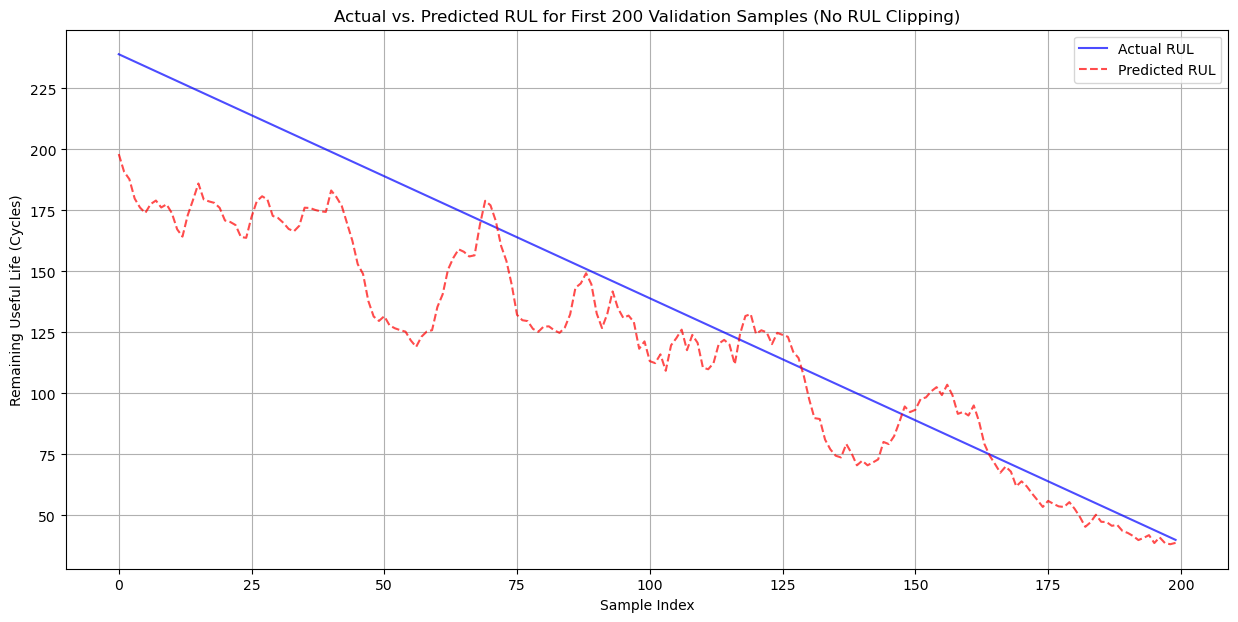

Validation evaluation complete.


In [10]:
print("\nStep 8: Re-evaluating Model Performance on Validation Data...")
val_loss = model.evaluate(X_val, y_val, verbose=0)
val_rmse = math.sqrt(val_loss)
val_mae = mean_absolute_error(y_val, model.predict(X_val).flatten())

print(f"Validation MSE: {val_loss:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation MAE: {val_mae:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

y_val_pred = model.predict(X_val).flatten()
plot_samples = 200

plt.figure(figsize=(15, 7))
plt.plot(y_val[:plot_samples], label='Actual RUL', color='blue', alpha=0.7)
plt.plot(y_val_pred[:plot_samples], label='Predicted RUL', color='red', linestyle='--', alpha=0.7)
plt.title(f'Actual vs. Predicted RUL for First {plot_samples} Validation Samples (No RUL Clipping)')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life (Cycles)')
plt.legend()
plt.grid(True)
plt.show()
print("Validation evaluation complete.")

In [11]:
print("\nStep 9: Preparing and Evaluating Final Test Data (test_FD001.txt)...")

df_test = pd.read_csv('test_FD001.txt', sep=' ', header=None)
df_test.drop([26, 27], axis=1, inplace=True)
df_test.columns = col_names
print("Test data loaded successfully.")


Step 9: Preparing and Evaluating Final Test Data (test_FD001.txt)...
Test data loaded successfully.


In [12]:
for col in rolling_features_base:
    df_test[f'{col}_rolling_mean_{window_size}'] = df_test.groupby('unit')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    df_test[f'{col}_rolling_std_{window_size}'] = df_test.groupby('unit')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())

df_test.fillna(0, inplace=True)

In [13]:
df_test[features_to_scale] = scaler.transform(df_test[features_to_scale])

In [14]:
true_rul = pd.read_csv('RUL_FD001.txt', sep=' ', header=None)
true_rul.drop([1], axis=1, inplace=True)
true_rul.columns = ['RUL']

In [15]:
X_final_pred = []
y_true_final_list = []

for unit_id in df_test['unit'].unique():
    unit_data = df_test[df_test['unit'] == unit_id]
    if len(unit_data) >= sequence_length:
        seq = unit_data.iloc[-sequence_length:][features_to_scale].values
        X_final_pred.append(seq)
        y_true_final_list.append(true_rul.iloc[unit_id - 1]['RUL'])
    else:
        print(f"Warning: Unit {unit_id} has fewer than {sequence_length} cycles. Skipping for prediction.")

X_final_pred = np.array(X_final_pred)
y_true_final = np.array(y_true_final_list)

print(f"Shape of X_final_pred (sequences for test engines): {X_final_pred.shape}")
print(f"Shape of y_true_final (true RULs for test engines): {y_true_final.shape}")

Shape of X_final_pred (sequences for test engines): (100, 30, 51)
Shape of y_true_final (true RULs for test engines): (100,)


In [16]:
y_pred_final = model.predict(X_final_pred)
y_pred_final = y_pred_final.flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [17]:
final_mse = mean_squared_error(y_true_final, y_pred_final)
final_rmse = math.sqrt(final_mse)
final_mae = mean_absolute_error(y_true_final, y_pred_final)

print(f"\nFinal Test Set MSE: {final_mse:.4f}")
print(f"Final Test Set RMSE: {final_rmse:.4f}")
print(f"Final Test Set MAE: {final_mae:.4f}")


Final Test Set MSE: 800.0866
Final Test Set RMSE: 28.2858
Final Test Set MAE: 19.6680


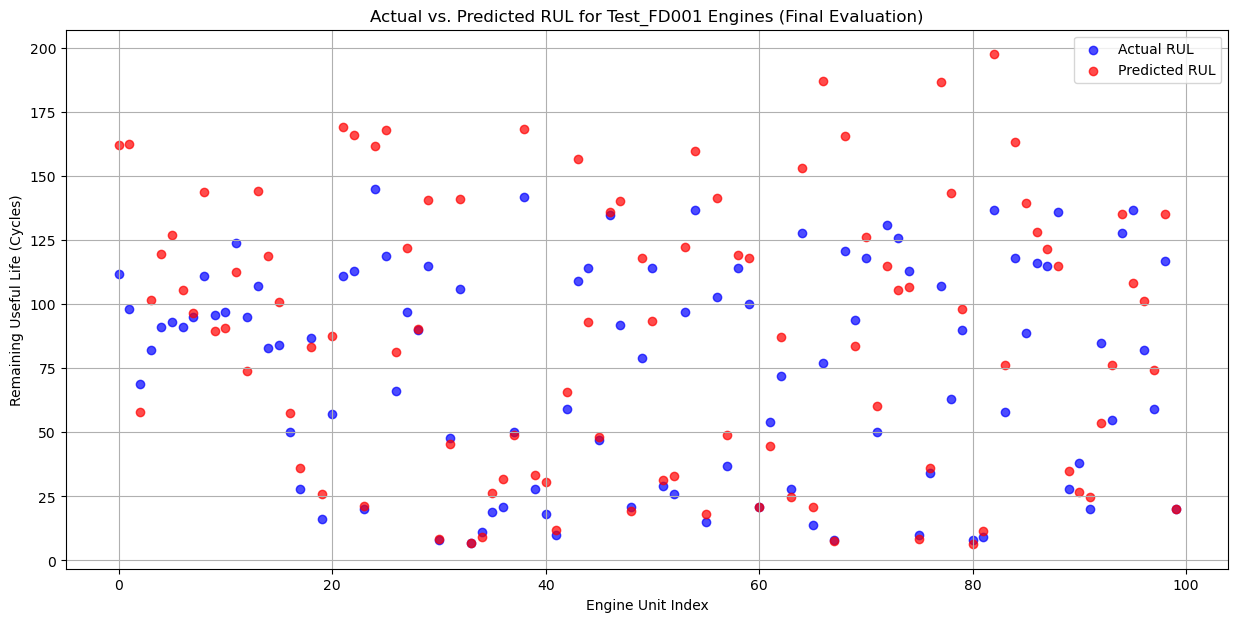


--- RUL Prediction Pipeline Complete ---


In [18]:
plt.figure(figsize=(15, 7))
plt.scatter(range(len(y_true_final)), y_true_final, label='Actual RUL', color='blue', alpha=0.7)
plt.scatter(range(len(y_pred_final)), y_pred_final, label='Predicted RUL', color='red', alpha=0.7)
plt.title('Actual vs. Predicted RUL for Test_FD001 Engines (Final Evaluation)')
plt.xlabel('Engine Unit Index')
plt.ylabel('Remaining Useful Life (Cycles)')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- RUL Prediction Pipeline Complete ---")